In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import networkx as nx
from scipy import optimize
from sklearn.metrics import roc_auc_score
from utils_eugene import get_all_atom_types, weisfeiler_lehman, WLK

Reading the data:

In [2]:
with open('data/training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

with open('data/test_data.pkl', 'rb') as file:
    test_graphs = pkl.load(file)

with open('data/training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

Plotting the data:

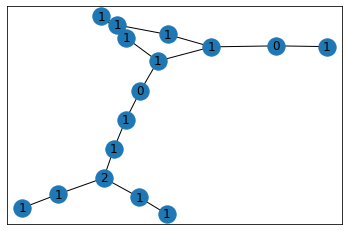

In [3]:
idx=0
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

Kernel SVC that takes as input the Gram matrices:

In [4]:
class KernelSVC:
    def __init__(self, C, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C
        self.alpha = None
        self.epsilon = epsilon
    
    def fit(self, G, y):
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = G
        y = y*2-1 # rescaling values to -1, 1
        self.y = y

        # Lagrange dual problem
        def loss(alpha):
            ay = np.multiply(alpha, y)
            return 0.5*np.dot(ay, K@ay) - np.sum(alpha)

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return np.dot(np.diag(y)@K@np.diag(y), alpha) - np.ones(N)

        # function defining the equality constraint
        fun_eq = lambda alpha: np.dot(alpha, y)
        # jacobian wrt alpha of the  equality constraint
        jac_eq = lambda alpha: y
        # function defining the inequality constraint
        fun_ineq = lambda alpha: (
            np.append(np.zeros(N), self.C*np.ones(N)) - np.vstack((-np.eye(N), np.eye(N)))@alpha
        )
        # jacobian wrt alpha of the  inequality constraint
        jac_ineq = lambda alpha: - np.vstack((-np.eye(N), np.eye(N)))
        
        constraints = ({'type': 'eq', 'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq, 'jac': jac_ineq})

        optRes = optimize.minimize(
            fun=lambda alpha: loss(alpha),
            x0=np.ones(N),
            method='SLSQP',
            jac=lambda alpha: grad_loss(alpha),
            constraints=constraints,
            options={'disp': True}
        )
        self.alpha = optRes.x

        # Useful to simplify notations:
        ay = np.multiply(self.alpha, y)

        # Indices of support vectors:
        support_idx = np.where((self.alpha < self.C - self.epsilon) & (self.alpha > self.epsilon))
        print(f'Found {len(support_idx)} support vectors.')

        # Offset of the classifier
        self.b = np.median(y[support_idx] - K[support_idx]@ay)
        print(f'b = {self.b}')

        # RKHS norm of the function f
        self.norm_f = np.sqrt(np.dot(ay, K@ay))
        print(f'||f|| = {self.norm_f}')

    ### Implementation of the separating function $f$
    def separating_function(self, G):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = G
        ay = np.multiply(self.alpha, self.y)
        return K@ay
    
    def predict(self, G):
        """ Predict y values in {0, 1} """
        d = self.separating_function(G)
        return (d+self.b) > 0

In [14]:
N_train, N_val = 2000, 1000

X_train = []
for i in range(N_train):
    X_train.append(weisfeiler_lehman(train_graphs[i], h=6))
y_train = train_labels[:N_train]

X_val = []
for i in range(N_train, N_train+N_val):
    X_val.append(weisfeiler_lehman(train_graphs[i], h=6))
y_val = train_labels[N_train:N_train+N_val]

Computing the Gram matrices:

In [15]:
G_train = np.zeros((N_train, N_train))

for i in range(N_train):
    for j in range(i, N_train):
        g = WLK(X_train[i], X_train[j])
        G_train[i,j] = g
        G_train[j,i] = g

In [16]:
G_val = np.zeros((N_val, N_train))
for i in range(N_val):
    for j in range(N_train):
        G_val[i,j] = WLK(X_val[i], X_train[j])

In [17]:
C=100.
model = KernelSVC(C=C)
model.fit(G_train, y_train)

Found 1 support vectors.
b = 413566.5
||f|| = 27192.53645763852


In [18]:
y_pred = model.predict(G_val)

In [19]:
y_pred.sum()/len(y_pred)

0.7

In [22]:
roc_auc_score(y_val, y_pred)

0.440995814734188

In [19]:
Yte = {'Prediction' : test_preds}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('test_pred.csv', index_label='Id')

NameError: name 'test_preds' is not defined